In [1]:
from iuvs import io

In [2]:
io.level1apath

PosixPath('/maven_iuvs/stage/products/level1a')

In [3]:
p = list(io.l1a_darks())[0]

Searching for *dark*.fits.gz


In [4]:
p.as_posix()

'/maven_iuvs/stage/products/level1a/mvn_iuv_l1a_apoapse-orbit00263-fuvdark_20141117T080111_v00_r00.fits.gz'

In [5]:
iuvs_fnames = []
for fname in io.l1a_filenames():
    iuvs_fnames.append(io.Filename(fname))

In [6]:
import pandas as pd

In [7]:
s = pd.Series(iuvs_fnames)

In [8]:
df = pd.DataFrame()

In [10]:
for item in ['phase', 'cycle_orbit', 'mode', 'channel', 'time', 'level', 'version', 'revision']:
    df[item] = s.map(lambda x: getattr(x, item))

In [11]:
df['channel']=df.channel.astype('category')

In [12]:
df.dtypes

phase                  object
cycle_orbit            object
mode                   object
channel              category
time           datetime64[ns]
level                  object
version                object
revision               object
dtype: object

In [13]:
df.head()

,phase,cycle_orbit,mode,channel,time,level,version,revision
0,IPH2,cycle00095,mode040,fuv,2014-05-24 23:45:52,l1a,v00,r00
1,periapse,orbit00425,N/A,fuv,2014-12-18 04:51:21,l1a,v00,r00
2,apoapse,orbit00352,N/A,muv,2014-12-04 08:43:54,l1a,v00,r00
3,IPH2,cycle00012,mode031,fuv,2014-04-22 16:22:45,l1a,v00,r00
4,periapse,orbit00111,mode0001,muv,2014-10-19 01:21:49,l1a,v00,r00


In [14]:
df.channel.value_counts()

fuv        8199
muv        7728
fuvdark    3808
muvdark    3433
echdark    1529
ech         790
dtype: int64

In [20]:
d = {'muv':1, 'muvdark':2, 'fuv':3, 'fuvdark':4, 'ech':5, 'echdark':6}
df['channel_int'] = df.channel.map(d)

In [15]:
df.describe()

,phase,cycle,mode,channel,time,level,version,revision
count,25487,25487,25487,25487,25487,25487,25487,25487
unique,14,252,82,6,14476,1,1,1
top,IPH2,orbit00002,mode020,fuv,2014-06-27 15:27:14,l1a,v00,r00
freq,14291,1177,5600,8199,2,25487,25487,25487
first,NaN,NaN,NaN,NaN,2013-12-11 21:02:18,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2014-11-16 05:26:28,NaN,NaN,NaN


In [16]:
df.phase.value_counts()

IPH2        14291
IPH1         3023
early        2861
IPH3         1000
apoapse       960
ISON2         691
periapse      640
APP2          576
ISON1         520
outbound      440
APP1          257
APP1A         112
inbound        60
comet          56
dtype: int64

In [22]:
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

In [23]:
df.head()

,phase,cycle,mode,channel,level,version,revision,channel_int
time,,,,,,,,
2013-12-11 21:02:18,ISON1,cycle01,mode01,fuvdark,l1a,v00,r00,4
2013-12-11 21:03:22,ISON1,cycle01,mode01,fuv,l1a,v00,r00,3
2013-12-11 21:40:02,ISON1,cycle01,mode01,fuvdark,l1a,v00,r00,4
2013-12-11 21:41:08,ISON1,cycle01,mode01,fuv,l1a,v00,r00,3
2013-12-11 22:17:49,ISON1,cycle01,mode01,fuvdark,l1a,v00,r00,4


In [25]:
%matplotlib qt

In [28]:
fig, ax = plt.subplots()
df.channel_int.plot(style='*',ax=ax)
ax.set_ylim(ymin=0)

(0, 6.0)

In [20]:
df.groupby([df.index]).size().value_counts()

2    11011
1     3465
dtype: int64

In [21]:
df['2014-06-27 15:27:14']

,phase,cycle,mode,channel,level,version,revision
time,,,,,,,
2014-06-27 15:27:14,IPH2,cycle00196,mode031,fuv,l1a,v00,r00
2014-06-27 15:27:14,IPH2,cycle00196,mode031,muv,l1a,v00,r00


In [69]:
doubles = !ls {root}/*IPH2-cycle00196*mode031*20140627T152714*

In [26]:
plt.style.use('ggplot')

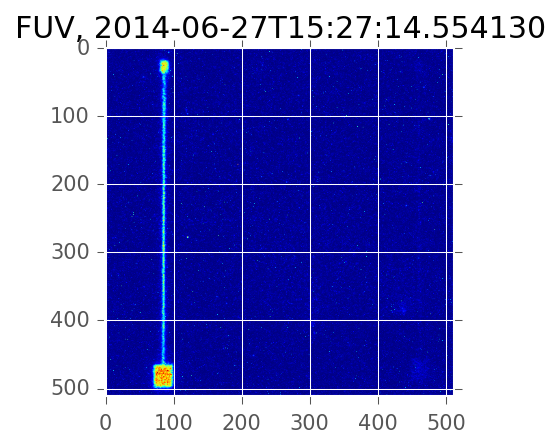

In [27]:
plot_img_data(doubles[0])

In [156]:
import datetime as dt
from astropy.io import fits
import gzip
import matplotlib.pyplot as plt
import os

class IUVS_Filename:
    def __init__(self, fname):
        tokens = fname.split('_')
        self.mission, self.instrument = tokens[:2]
        self.level = tokens[2]
        self.phase = tokens[3]
        self.timestr, self.version = tokens[4:6]
        self.revision = tokens[6].split('.')[0]
        phasetokens = self.phase.split('-')
        self.phase, self.cycle, self.mode, self.channel = phasetokens
        self.time = dt.datetime.strptime(self.timestr,
                                         '%Y%m%dT%H%M%S')


class FitsBinTable:
    def __init__(self, hdu):
        self.header = hdu.header
        self.data = pd.DataFrame(hdu.data).T
        
class IUVSReader:
    """For Level1a"""
    def __init__(self, fname):
        infile = gzip.open(fname, 'rb')
        self.fname = os.path.basename(fname)
        self.hdulist = fits.open(infile)
        self.integration = FitsBinTable(self.hdulist[1])
        self.engineering = FitsBinTable(self.hdulist[2])
        self.binning = self.hdulist[3]
        self.pixelgeo = self.hdulist[4]
        self.spacecraftgeo = self.hdulist[5]
        self.observation = self.hdulist[6]
        
    @property
    def img_header(self):
        imgdata = self.hdulist[0]
        return imgdata.header

    @property
    def img(self):
        return self.hdulist[0].data

    @property
    def capture(self):
        string = self.img_header['CAPTURE']
        import datetime as dt
        cleaned = string[:-3]+'0'
        time = dt.datetime.strptime(cleaned, '%Y/%j %b %d %H:%M:%S.%f')
        return time

    def plot_img_data(self):
        time = parse_capture(self.img_header['CAPTURE'])
        fig, ax = plt.subplots()#figsize=(8, 6))
        ax.imshow(self.img)
        ax.set_title("{xuv}, {time}".format(time=time.isoformat(),
                                            xuv=self.img_header['XUV']))
        return ax




In [86]:
ds = IUVSReader(doubles[0])

In [118]:
all_headers = open('all_headers.txt', 'w')
for i, hdu in enumerate(ds.hdulist):
    all_headers.write('----HDU: {0} \n\r'.format(i))
    all_headers.write(repr(hdu.header))
    all_headers.write('\n\r')
all_headers.close()

In [119]:
ds.img_header['MIR_DEG']

45.0

In [120]:
ds.integration.data

,0
TIMESTAMP,4.571548e+08
ET,4.571549e+08
UTC,2014/178 Jun 27 15:27:14.55413UTC
MIRROR_DN,29322
MIRROR_DEG,44.99725
FOV_DEG,89.99451
LYA_CENTROID,65535


In [126]:
import glob
fnames = glob.glob(root+'/*.fits.gz')

In [132]:
from IPython import parallel
rc = parallel.Client()

In [133]:
dview = rc.direct_view()

In [134]:
lview = rc.load_balanced_view()

In [140]:
%%px 
key_errors=[]
results = []

In [188]:
def find_big_deltas(fname):
    fitsdata = IUVSReader(fname)
    mir_deg1 = fitsdata.img_header['MIR_DEG']
    mir_deg2 = fitsdata.integration.data.get_value('MIRROR_DEG', 0)
    return mir_deg1/mir_deg2

In [189]:
ratios = []
n = 100
for i,fname in enumerate(fnames[:n]):
    print(i/n)
    ratio = find_big_deltas(fname)
    if abs(ratio) > 2:
        print(fname)
    ratios.append(ratio)

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
/maven_iuvs/stage/products/level1a/mvn_iuv_l1a_IPH1-cycle00023-mode060-fuv_20140410T141518_v00_r00.fits.gz
0.62
/maven_iuvs/stage/products/level1a/mvn_iuv_l1a_IPH2-cycle00203-mode060-muv_20140630T035343_v00_r00.fits.gz
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


count    100.000000
mean       0.798660
std        1.421604
min       -9.102222
25%        1.000058
50%        1.000071
75%        1.002890
max        1.011358
dtype: float64

In [190]:
ds = IUVSReader('/maven_iuvs/stage/products/level1a/mvn_iuv_l1a_IPH1-cycle00023-mode060-fuv_20140410T141518_v00_r00.fits.gz')

In [196]:
ds.img_header['MIR_DEG']

-0.025

In [193]:
df = ds.integration.data

In [194]:
df.get_value('MIRROR_DEG', 0)

0.00274658203125

In [195]:
ratios

[1.011358024691358,
 1.0000610388817677,
 0.9954787585092881,
 1.0000741804419213,
 1.0000610388817677,
 1.011358024691358,
 1.0000610388817677,
 1.011358024691358,
 1.011358024691358,
 1.0000956122562226,
 1.0000610388817677,
 0.9102222222222223,
 1.0004109076109076,
 1.011358024691358,
 1.0000426922721817,
 1.0000426922721817,
 1.0000610388817677,
 1.0057704112952732,
 1.0000610388817677,
 1.0000610388817677,
 1.0000737973674572,
 0.9102222222222223,
 1.011358024691358,
 1.011358024691358,
 1.000043535246735,
 1.0000426922721817,
 1.0000610388817677,
 0.9996287972144013,
 1.0000592110319881,
 1.011358024691358,
 1.0000610388817677,
 1.0002442002442002,
 1.0002442002442002,
 1.000454473374049,
 1.0000610388817677,
 1.0000610388817677,
 1.0000610388817677,
 1.0000411445128576,
 1.0008275487701441,
 1.011358024691358,
 0.99544339497682,
 0.9996287972144013,
 0.9996287972144013,
 1.0000610388817677,
 1.0000610388817677,
 1.000092264416315,
 1.000454473374049,
 1.011358024691358,
 1.00004

In [202]:
pd.Series(ratios).describe()

count    100.000000
mean       0.798660
std        1.421604
min       -9.102222
25%        1.000058
50%        1.000071
75%        1.002890
max        1.011358
dtype: float64

In [203]:
pd.Series(ratios).median()

1.0000706298212494